In [6]:
import numpy as np
import scipy
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector, state_fidelity, Operator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.primitives import Estimator, Sampler
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.linalg import expm, cosm
import warnings
import time

In [2]:
import qiskit
print(qiskit.__version__)

1.3.1


In [6]:
import qiskit_aer
print(qiskit_aer.__version__)

0.15.1


In [3]:
def get_hamiltonian(nqubits):
    J=1/np.sqrt(2)
    ZZ_tuples = [('ZZ', [i, i+1], J) for i in range(nqubits-1)]
    ZZ_tuples += [('ZZ', [nqubits-1, 0], J)]
    X_tuples = [("X", [i], J) for i in range(nqubits)]
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()
    
def ansatz_hamiltonian(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits)
    t = 0
    for i in range(nqubits):
        circuit.h(i)
    for idepth in range(depth):
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0
            circuit.rzz(params[t], i, j)
            t += 1
        circuit.barrier()
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0    
            circuit.rx(params[t], i)
            t += 1
    return circuit    
    
def ansatz_hea(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits)
    t = 0
    for idepth in range(depth):
        for i in range(nqubits):
            circuit.ry(params[t], i)
            t += 1
        circuit.barrier()
        for i in range(nqubits-1):
            circuit.cx(i, i+1)
    return circuit    
   
def cost_function1(params, nqubits, depth, error_rate):
    hamiltonian =  get_hamiltonian(nqubits)
    circuit =  ansatz_hamiltonian(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    sim_d = AerSimulator(noise_model=noise_model)
    circuit.save_statevector() 
    if error_rate == 0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
        circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result = simulator.run(circuit).result()
    u=result.data(0)['statevector'].data
    expectation = (u.conj().dot(hamiltonian.to_matrix())).dot(u)
    return expectation.real
    
def cost_function2(nqubits, error_rate, params):
    hamiltonian =  get_hamiltonian(nqubits)
    circuit =  ansatz_hea(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,['cx'])
    sim_d = AerSimulator(noise_model=noise_model)
    circuit.save_statevector()
    if error_rate == 0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
        circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result = simulator.run(circuit).result()
    u=result.data(0)['statevector'].data
    expectation = (u.conj().dot(hamiltonian.to_matrix())).dot(u)
    return expectation.real


    # print(
    #     f"{intermediate_result.fun}"
    #     )
    #with open('intermediate_values_hva.txt', 'a') as file:
     #   file.write(f'Intermediate values: {intermediate_result.fun}\n')
    


In [24]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 0
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate = []
def callback(intermediate_result):
    result_intermediate.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)

In [32]:
print(result_intermediate)

[-1.1465461343347791, -2.602898247291077, -2.848094012158368, -3.206002304191979, -3.319994326750565, -3.4384044683031587, -3.53736241079297, -3.6054730572544242, -3.6484027579854708, -3.662023065487695, -3.6704427744721184, -3.6765936854301247, -3.6807427635642345, -3.6865485932013033, -3.6930312588906897, -3.694791979762086, -3.6951774979858847, -3.6953272773565558, -3.6954448664900577, -3.6954921883044745, -3.695513649637448, -3.695517967045898, -3.6955181144876983, -3.695518129745835, -3.6955181300339923]


In [37]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-4
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate1 = []
def callback(intermediate_result):
    result_intermediate1.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)

In [38]:
result_intermediate1

[-1.1465461430601096,
 -2.602452468967515,
 -2.8734212822146037,
 -3.1609705837628272,
 -3.3197889297182632,
 -3.4292381951979976,
 -3.5358713564207496,
 -3.6016709163906078,
 -3.636319878890746,
 -3.6549950094072403,
 -3.6685683259495034,
 -3.675078932505813,
 -3.678036384247927,
 -3.682644053704772,
 -3.6888701580489864,
 -3.6933218484069967,
 -3.6949428535405873,
 -3.6952582083141716,
 -3.6953520972773513,
 -3.695461681174133,
 -3.695513131336012,
 -3.6955175211172913,
 -3.695518030999416,
 -3.6955181237134704,
 -3.69551812973178,
 -3.6955181300331934]

In [40]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-3
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate2 = []
def callback(intermediate_result):
    result_intermediate2.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)

In [42]:
result_intermediate2

[0.47066341608655815, 0.41037442031684024]

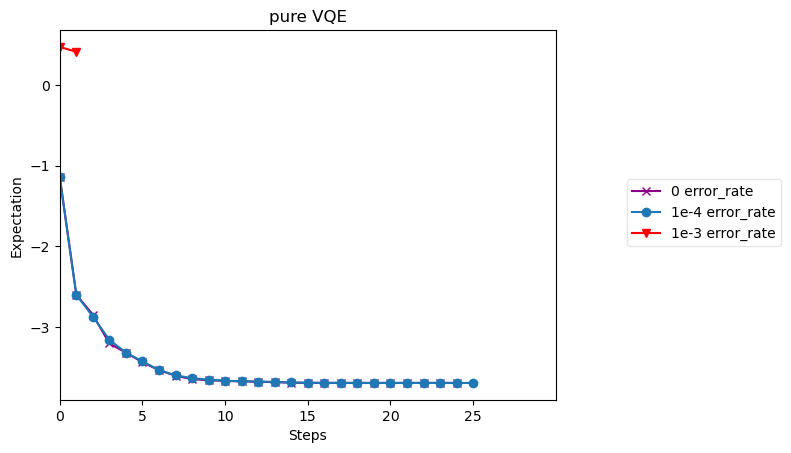

In [62]:
x = np.linspace(0, 200)  # 11个点
y = result_intermediate  # 只有6个点
y1 = result_intermediate1
y2 = result_intermediate2
# 创建figure和axes对象
fig, ax = plt.subplots()
# 使用axes对象绘制数据，不指定x值，默认使用索引
ax.plot(y, label='0 error_rate', marker="x", c="darkmagenta", ls="-")
ax.plot(y1, label='1e-4 error_rate', marker='o', linestyle='-')
ax.plot(y2, label='1e-3 error_rate', marker="v", c="r", ls="-")
legend = fig.legend(
            *ax.get_legend_handles_labels(),
            bbox_to_anchor=(1.0, 0.5),
            loc="center left",
            framealpha=0.5,
        )
# 设置x轴刻度为索引值
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 30, 5))
# 添加标题和标签
ax.set_title('pure VQE')
ax.set_xlabel('Steps')
ax.set_ylabel('Expectation')
# 显示网格
ax.grid(False)
# 展示图形
plt.show()

In [4]:
np.random.seed(42)  # Example seed
nqubits = 8
J = 1/np.sqrt(2)
depth = 3
error_rate = 0
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)#, args=(nqubits, error_rate)

-0.9905692515755558
-3.6197504290283975
-5.200674462326649
-5.973694170876433
-6.011125328238565
-6.347514519410105
-6.756220529313845
-6.9150283700816875
-6.93209174945375
-6.945294317568429
-6.958535528042241
-6.966055393102237
-6.970821826033266
-6.97531837172391
-6.9775770916858875
-6.980717970380259
-6.983519372032209
-6.986681305105318
-6.990423603041158
-6.9954091900981705
-6.999147885046877
-7.003520467299889
-7.006908773007503
-7.009629013600507
-7.011544702427889
-7.01366159904866
-7.014932747393546
-7.015467683365535
-7.016038988299014
-7.0164419375691285
-7.016843042784033
-7.017424253421718
-7.017925930832738
-7.018493377536426
-7.019231900294368
-7.01999845541088
-7.020849673780115
-7.0219459083253355
-7.022238022148327
-7.022687161847659
-7.023391966763172
-7.024295235604455
-7.02491681760316
-7.025614461390854
-7.026706022912716
-7.027682511193494
-7.028522788024732
-7.029924586544922
-7.03194503714421
-7.033451931164286
-7.0355117385197135
-7.038346622332135
-7.0396492

In [5]:
hamiltonian = get_hamiltonian(8)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
print(emin)

-7.2490195708231004


In [71]:
hamiltonian = get_hamiltonian(8)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
print(emin)

-7.249019570823107


TO BE DONE

In [5]:
nqubits = 8
depth = 3
parameter = np.array(np.random.random(2*nqubits*depth))
circuit = ansatz_hamiltonian(nqubits, depth, parameter)
circuit = circuit.decompose(reps=2)
count = []
count.append(circuit.depth()) #depth, total gate, nonlocal gates
count.append(len(circuit))
count.append(circuit.num_nonlocal_gates())
print(count)

[76, 107, 48]


In [68]:
a = 0.0003
print(f"{a:.2e}")

3.00e-04


In [ ]:

start_time = time.time()

In [8]:
## Sampler
# 1. A quantum circuit for preparing the quantum state |000> + i |111>
qc_example = QuantumCircuit(3)
qc_example.h(0)          # generate superpostion
qc_example.p(np.pi/2,0)  # add quantum phase
qc_example.cx(0,1)       # 0th-qubit-Controlled-NOT gate on 1st qubit
qc_example.cx(0,2)       # 0th-qubit-Controlled-NOT gate on 2nd qubit
operator = SparsePauliOp.from_list([("XXY", 1), ("XYX", 1), ("YXX", 1), ("YYY", -1)])
# 2. Add the classical output in the form of measurement of all qubits
qc_measured = qc_example.measure_all(inplace=False)
# 3. Execute using the Sampler primitive
sampler = StatevectorSampler()
job = sampler.run([qc_measured], shots=1000)
result = job.result()
print(f" > Counts: {result[0].data.meas.get_counts()}")

 > Counts: {'000': 496, '111': 504}


In [9]:
import qiskit
print(qiskit.__version__)

1.3.1


In [10]:
## Estimator
estimator = StatevectorEstimator()
job = estimator.run([(qc_example, operator)], precision=1e-3)
result = job.result()
print(f" > Expectation values: {result[0].data.evs}")

 > Expectation values: 4.000392893466742


In [13]:
## Estimator
estimator = Estimator()
job = estimator.run(qc_example, operator, precision=1e-3)
result = job.result()
result.values
#print(f" > Expectation values: {result[0].data.evs}")

C:\Users\schauue\AppData\Local\Temp\ipykernel_45308\316892537.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


array([4.])

In [14]:
hamiltonian = operator
min(np.linalg.eigvalsh(hamiltonian.to_matrix()))

np.float64(-4.0)

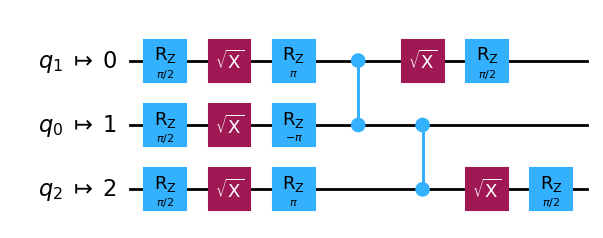

In [117]:
qc_transpiled = transpile(qc_example, basis_gates = ['cz', 'sx', 'rz'], coupling_map =[[0, 1], [1, 2]] , optimization_level=3)
qc_transpiled.draw('mpl')

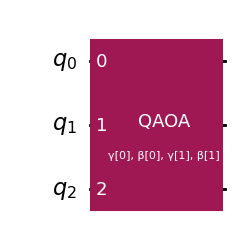

In [119]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

operator = SparsePauliOp.from_list([("XXY", 1), ("XYX", 1), ("YXX", 1), ("YYY", -1)])
circuit = QAOAAnsatz(operator, reps=2)
circuit.draw('mpl')

### Use estimator

In [37]:
def cost_function(params, nqubits, depth, error_rate):
    hamiltonian =  get_hamiltonian(nqubits)
    circuit =  ansatz_hamiltonian(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    #circuit.save_statevector()
    if error_rate == 0:
        estimator = EstimatorV2()
        #print('error rate is 0')
    else:
        #print('error rate is ' + str(error_rate))
        estimator = EstimatorV2(options=dict(backend_options=dict(noise_model=noise_model)))
        #circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result =estimator.run([(circuit, hamiltonian)]).result()
    expectation=result[0].data.evs
    return expectation.real

In [34]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 0
parameter = np.array(np.random.random(2*nqubits*depth))
expectation = cost_function(parameter, nqubits, depth, error_rate)
expectation

error rate is 0


array(1.32826405)

In [35]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-3
parameter = np.array(np.random.random(2*nqubits*depth))
expectation = cost_function(parameter, nqubits, depth, error_rate)
expectation

error rate is 0.001


array(1.21942165)

In [41]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 0
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate = []
def callback(intermediate_result):
    result_intermediate.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
result_intermediate

[-1.146546132116061,
 -2.6028982372512375,
 -2.8480938565785943,
 -3.2060020690785107,
 -3.3199942708126375,
 -3.4384043636342216,
 -3.537362372341709,
 -3.6054730441231895,
 -3.6484027209174577,
 -3.662023081540118,
 -3.670442736465896,
 -3.676593660765858,
 -3.6807427454988653,
 -3.686548537845189,
 -3.69303122725566,
 -3.6947919802622278,
 -3.695177500516187,
 -3.6953272807143134,
 -3.6954448697713076,
 -3.69549218687719,
 -3.6955136487462426,
 -3.695517966962232,
 -3.695518114522142,
 -3.695518129754621,
 -3.6955181300347575]

In [42]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-3
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate1 = []
def callback(intermediate_result):
    result_intermediate1.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
result_intermediate1

[-1.014951022297982,
 -2.3234147826305653,
 -2.628876109951761,
 -2.945502919302787,
 -2.9907658795551617,
 -3.070773314247404,
 -3.155002434364846,
 -3.1881729974263306,
 -3.228155795745386,
 -3.2466486215289283,
 -3.269997965451104,
 -3.2783083601528995,
 -3.282129020653614,
 -3.286296032760394,
 -3.2909528692601535,
 -3.2970658006091584,
 -3.301774347881438,
 -3.3041595866941162,
 -3.305233528909136,
 -3.3065610213327408,
 -3.307444270374015,
 -3.3081628673311996,
 -3.308691992558266,
 -3.3092181226120974,
 -3.3094764673855996,
 -3.3097958677925803,
 -3.310146046220884,
 -3.3107988674877133,
 -3.311767591054636,
 -3.3125369410784553,
 -3.3136015556012115,
 -3.31464487903306,
 -3.3153933247625367,
 -3.316167360728539,
 -3.3175383010918584,
 -3.319097885503549,
 -3.3200892570393097,
 -3.3214314115319405,
 -3.3225857082033925,
 -3.323525509334881,
 -3.324500844474141,
 -3.3255678845448697,
 -3.3271378892030468,
 -3.329128173158005,
 -3.330902818988343,
 -3.331551824593948,
 -3.33222696

In [43]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-4
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate2 = []
def callback(intermediate_result):
    result_intermediate2.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
result_intermediate2

[-1.1327336346553483,
 -2.573693251145439,
 -2.8268634973436604,
 -3.1862136373965844,
 -3.2858784353000847,
 -3.4041102239161303,
 -3.492750366533888,
 -3.5542639875867055,
 -3.5931666227636025,
 -3.6108328799941214,
 -3.6278525226539227,
 -3.634479225017325,
 -3.63877002341861,
 -3.6454104507345546,
 -3.65041175355045,
 -3.6530895817734876,
 -3.6538353642526946,
 -3.6540714007737414,
 -3.654196374589492,
 -3.654336282504428,
 -3.6543745248461215,
 -3.6543936359179003,
 -3.654398721412571,
 -3.654407107842274,
 -3.6544221910420602,
 -3.654450068229094,
 -3.654499772069532,
 -3.6545541809469215,
 -3.6546093246864477,
 -3.6546994170443257,
 -3.6547984622870437,
 -3.654814493600868,
 -3.6548427656683122,
 -3.654891689114158,
 -3.6549684788058565,
 -3.6550574205325432,
 -3.6550798614412185,
 -3.655118899653179,
 -3.6551794895569567,
 -3.655266340546341,
 -3.6553063796612233,
 -3.655364747612473,
 -3.655441063176196,
 -3.655552687011101,
 -3.6556170705094675,
 -3.6557173618011936,
 -3.6558

In [44]:
len(result_intermediate2)

217

In [46]:
hamiltonian = get_hamiltonian(4)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emin

np.float64(-3.6955181300451487)

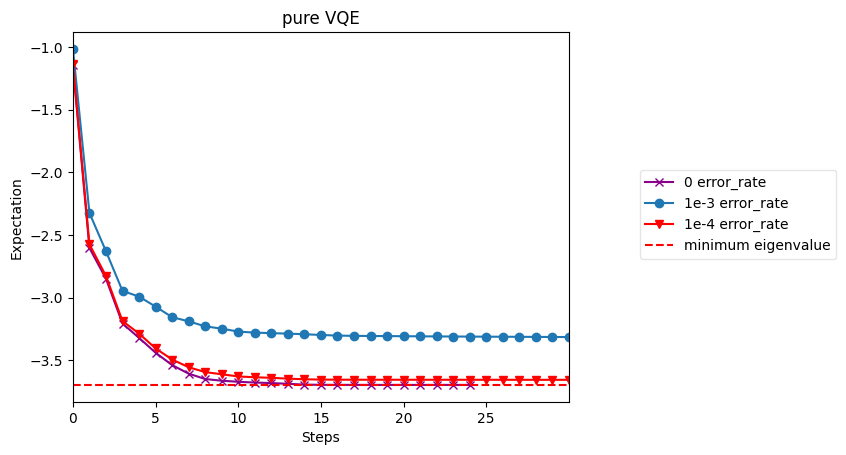

In [48]:
x = np.linspace(0, 250)  # 11个点
y = result_intermediate  # 只有6个点
y1 = result_intermediate1
y2 = result_intermediate2
horizontal_line_value = emin
# 创建figure和axes对象
fig, ax = plt.subplots()
# 使用axes对象绘制数据，不指定x值，默认使用索引
ax.plot(y, label='0 error_rate', marker="x", c="darkmagenta", ls="-")
ax.plot(y1, label='1e-3 error_rate', marker='o', linestyle='-')
ax.plot(y2, label='1e-4 error_rate', marker="v", c="r", ls="-")
ax.axhline(y=horizontal_line_value, color='r', linestyle='--', label='minimum eigenvalue')
legend = fig.legend(
            *ax.get_legend_handles_labels(),
            bbox_to_anchor=(1.0, 0.5),
            loc="center left",
            framealpha=0.5,
        )
# 设置x轴刻度为索引值
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 30, 5))
# 添加标题和标签
ax.set_title('pure VQE')
ax.set_xlabel('Steps')
ax.set_ylabel('Expectation')
# 显示网格
ax.grid(False)
# 展示图形
plt.show()

In [51]:
abs(emin-result_intermediate1[-1])/abs(emin)*100

np.float64(9.086366010844452)

## test

In [52]:
def cost_function1(params, nqubits, depth, error_rate):
    hamiltonian =  get_hamiltonian(nqubits)
    circuit =  ansatz_hamiltonian(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    #circuit.save_statevector()
    if error_rate == 0:
        estimator = EstimatorV2()
        #print('error rate is 0')
    else:
        #print('error rate is ' + str(error_rate))
        estimator = EstimatorV2(options=dict(backend_options=dict(noise_model=noise_model)))
        #circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result =estimator.run([(circuit, hamiltonian)]).result()
    expectation=result[0].data.evs
    return expectation.real
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-4
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate2temp = []
def callback(intermediate_result):
    result_intermediate2temp.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
result_intermediate2temp

[-1.1327336346553483,
 -2.573693251145439,
 -2.8268634973436604,
 -3.1862136373965844,
 -3.2858784353000847,
 -3.4041102239161303,
 -3.492750366533888,
 -3.5542639875867055,
 -3.5931666227636025,
 -3.6108328799941214,
 -3.6278525226539227,
 -3.634479225017325,
 -3.63877002341861,
 -3.6454104507345546,
 -3.65041175355045,
 -3.6530895817734876,
 -3.6538353642526946,
 -3.6540714007737414,
 -3.654196374589492,
 -3.654336282504428,
 -3.6543745248461215,
 -3.6543936359179003,
 -3.654398721412571,
 -3.654407107842274,
 -3.6544221910420602,
 -3.654450068229094,
 -3.654499772069532,
 -3.6545541809469215,
 -3.6546093246864477,
 -3.6546994170443257,
 -3.6547984622870437,
 -3.654814493600868,
 -3.6548427656683122,
 -3.654891689114158,
 -3.6549684788058565,
 -3.6550574205325432,
 -3.6550798614412185,
 -3.655118899653179,
 -3.6551794895569567,
 -3.655266340546341,
 -3.6553063796612233,
 -3.655364747612473,
 -3.655441063176196,
 -3.655552687011101,
 -3.6556170705094675,
 -3.6557173618011936,
 -3.6558